In [1]:
import torch #Redes neuronales
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torchvision

In [2]:
torch.cuda.is_available()

False

In [ ]:
#torch.cuda.current_device()

In [ ]:
#torch.cuda.get_device_name(0)

In [14]:
device = torch.device("cpu")

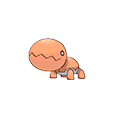

In [15]:
img = Image.open("C://Users//sebas//Downloads//archive (10)//images//trapinch.png") #Open image
img.thumbnail(size=(120,120)) #Make thumnbial
img

In [5]:
model = resnet50(weights="IMAGENET1K_V1") #Instanciamos el objeto
#model.to(device)

In [16]:
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
])

In [7]:
# convierte las imágenes en tensor (Aquí igualamos las resoluciones qls)
raw_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


# Cargar el dataset con solo ToTensor
raw_dataset = torchvision.datasets.ImageFolder(root='C:/Users/Tomás Lara/Desktop/Proyecto Oficial/PokemonData', transform=raw_transform)
raw_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=16, shuffle=True)

# Obtener un batch de imágenes sin normalizar
images, labels = next(iter(raw_loader))
classes = raw_dataset.classes

# Mostrar las imágenes en una cuadrícula
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Ejemplos", fontsize=16)

for i in range(16):
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))  # de [C,H,W] a [H,W,C]
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(classes[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
     


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'C:/Users/Tomás Lara/Desktop/Proyecto Oficial/PokemonData'

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = trainset.classes

100%|██████████| 170M/170M [00:26<00:00, 6.55MB/s] 


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # [B, 3, 32, 32] → [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # → [B, 32, 16, 16]
            nn.Conv2d(32, 64, 3, padding=1), # → [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)               # → [B, 64, 8, 8]
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

def evaluate(loader):
    model.eval()
    total, correct, loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = loss_total / total
    accuracy = correct / total
    return avg_loss, accuracy

In [19]:
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(testloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/40 - Train loss: 1.6490, Acc: 0.3894 | Val loss: 1.3104, Acc: 0.5250


KeyboardInterrupt: 

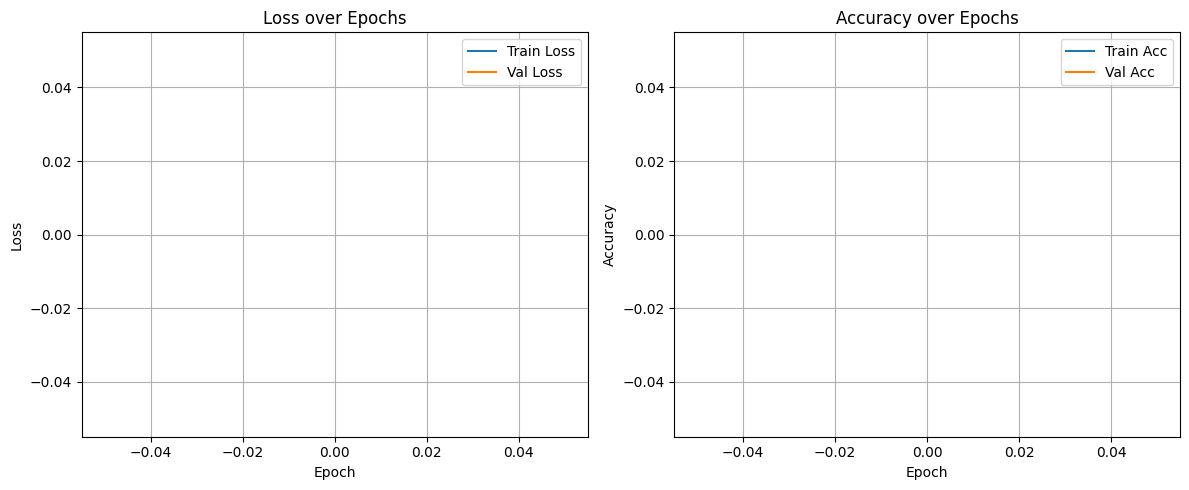

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()